# Simple example

In [179]:
from river import synth
from river import ensemble
from river import evaluate
from river import metrics
import matplotlib.pyplot as plt

# dataset = synth.ConceptDriftStream(seed=42, position=500, width=40).take(1000)
#
# model = ensemble.AdaptiveRandomForestClassifier(n_models=3,seed=42)
# metric = metrics.Accuracy()
#
# for x, y in dataset:
#     print(x, y)

In [180]:
# evaluate.progressive_val_score(dataset, model, metric)

# Order book prediction

In [181]:
from data.historical import Quote
from alpaca_trade_api.rest import REST, TimeFrame

In [182]:
aapl = Quote(REST(), 'SPY',start="2022-04-18", end="2022-04-18", limit=100000)
print(aapl.shape)
aapl.head(5)

C:\Users\Bora\anaconda3\envs\alpaca-research\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(99490, 43)


C:\Users\Bora\Insync\borabasa@gmail.com\Google Drive\GitHub\alpaca-research\data\historical.py:139: UserWarning: Aggregated features are non-causal in information-time. Use at least second-time-bars
  warnings.warn("Aggregated features are non-causal in information-time. Use at least second-time-bars")


,ask_price,ask_size,bid_price,bid_size,seconds_elapsed,hour,WAP,log_ret,spread,mid,...,spread_std,spread_max_move,spread_num_outliers,ask_size_mean,ask_size_sum,bid_size_mean,bid_size_sum,log_ret_realized_volatility,intensity,acceleration
timestamp_,,,,,,,,,,,,,,,,,,,,,
2022-04-18 08:00:02.013823398+00:00,435.81,4,435.69,5,2.0,8,435.756667,0.000013,0.12,435.750,...,0.008367,0.02,0,4.8,24,5.4,27,0.00003,5,4.0
2022-04-18 08:00:02.013923+00:00,435.81,5,435.69,5,2.0,8,435.750000,-0.000015,0.12,435.750,...,0.008367,0.02,0,4.8,24,5.4,27,0.00003,5,4.0
2022-04-18 08:00:02.013972+00:00,435.82,5,435.69,5,2.0,8,435.755000,0.000011,0.13,435.755,...,0.008367,0.02,0,4.8,24,5.4,27,0.00003,5,4.0
2022-04-18 08:00:02.014049+00:00,435.82,5,435.69,6,2.0,8,435.760909,0.000014,0.13,435.755,...,0.008367,0.02,0,4.8,24,5.4,27,0.00003,5,4.0
2022-04-18 08:00:02.016026+00:00,435.83,5,435.69,6,2.0,8,435.766364,0.000013,0.14,435.760,...,0.008367,0.02,0,4.8,24,5.4,27,0.00003,5,4.0


In [202]:
def labeler(data, cut_off=0.2):

    data['label'] = data.log_ret.shift(-1)
    data['label_ma'] = data.label.rolling(15).mean()
    data['label_std'] = data.label.rolling(15).std()
    data.dropna(inplace=True)
    data['label_'] = (data['label']-data['label_ma'])/data['label_std']
    data.label.loc[data.label_>cut_off] = 1
    # data.label.loc[data.label_>2*cut_off] = 2
    data.label.loc[data.label_<-cut_off] = -1
    # data.label.loc[data.label_<-2*cut_off] = -2
    data.label.loc[(cut_off>data.label_)&(data.label_>-cut_off)] = 0
    data.drop(columns=["label_ma", 'label_', 'label_std'], inplace=True)
    return data.iloc[:,:-1], data.iloc[:, -1]

def split(x, y, ratio=0.7):
    n_train = int(len(x)*ratio)
    return x.iloc[:n_train, :], y.iloc[:n_train], x.iloc[n_train:, :], y.iloc[n_train:]


features = aapl.df.groupby('seconds_elapsed').mean()
x, y = labeler(features)
x.shape
# x_train, y_train, x_test, y_test = split(x, y)
# x_train.shape

(7511, 42)

<AxesSubplot:ylabel='Frequency'>

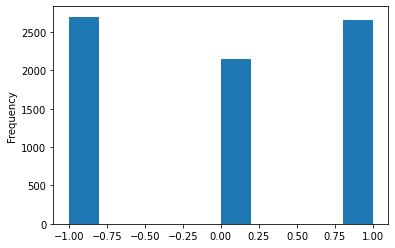

In [203]:
y.plot.hist()

In [204]:

model = ensemble.AdaptiveRandomForestClassifier(n_models=10,seed=42, max_depth=5)
metric = metrics.F1()
cm = metrics.ConfusionMatrix()
metric_vec = []
for x_, y_ in zip(x.values, y.values):
    x_ = dict(zip(x.columns, x_))
    y_pred = model.predict_proba_one(x_)
    model.learn_one(x_, y_)
    try:
        y_pred = max(y_pred, key=y_pred.get)
    except ValueError:
        continue
    metric.update(y_, y_pred)
    metric_vec.append(metric.get())
    cm.update(y_, y_pred)

In [205]:
metric

F1: 47.60%

In [206]:
cm

       -1.0    0.0   1.0    
-1.0   1,556   161     982  
 0.0   1,048   138     967  
 1.0   1,058   161   1,439  

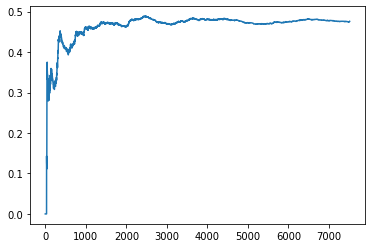

In [207]:
plt.plot(metric_vec)